In [11]:
import torch
import torch.nn as nn
import torch.optim
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import MultiStepLR
from torchvision.transforms import Compose
from models.fewshotv3 import FewShotSegV3
from models.fewshot import FewShotSeg
from models.fewshotv3Inet import FewShotSegV3Inet
import segmentation_models_pytorch as smp
from dataloaders.customized import voc_fewshot, coco_fewshot
from dataloaders.transforms import RandomMirror, Resize, ToTensorNormalize
from util.utils import set_seed, CLASS_LABELS
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
import numpy as np
from util.metric import Metric
from dataloaders.cityscape import Cityscape
from torchvision.transforms import Compose
from torchvision import transforms

In [12]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
    #set the device to gpu0
    torch.cuda.set_device(device=0)
else:
    device = torch.device('cpu')

In [13]:
input_size = (417, 417)
batch_size=1
steps=30000
lambda_PAR=1

In [14]:
# #Get the dataset functions from here
# dataset_name="VOC"
# if dataset_name == 'VOC':
#     gen_dataset = voc_fewshot
#     data_dir='../../data/Pascal/VOCdevkit/VOC2012/'
#     data_split='trainaug'
# elif dataset_name == 'COCO':
#     gen_dataset = coco_fewshot
#     data_dir='../../data/COCO/'
#     data_split='train'
# # else: 
# #     dataset=cityscape_fewshot

# labels = CLASS_LABELS[dataset_name][0]
# transforms = Compose([Resize(size=input_size),
#                         RandomMirror()])
# dataset = gen_dataset(
#     base_dir=data_dir,
#     split=data_split,
#     transforms=transforms,
#     to_tensor=ToTensorNormalize(),
#     labels=labels,
#     max_iters=batch_size*steps,
#     n_ways=1,
#     n_shots=1,
#     n_queries=1
# )

# train_loader = DataLoader(
#     dataset,
#     batch_size=batch_size,
#     shuffle=True,
#     num_workers=1,
#     pin_memory=True,
#     drop_last=True
# )

In [15]:
select_set=0
dataset_name="Cityscape"
if dataset_name == 'Cityscape':
    cityscapesPath = '../../data/Cityscape'
    dataset_size = 30000
 

    flip_transform = transforms.RandomHorizontalFlip(p=0.25)
    img_transforms = Compose([transforms.ToTensor(),
                          transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                          transforms.Resize(size=input_size),])
                          #flip_transform])
    mask_transforms = Compose([transforms.ToTensor(),
                          transforms.Resize(size=input_size),])
                          #flip_transform])

    dataset = Cityscape(cityscapesPath, dataset_size, labels=CLASS_LABELS[dataset_name][select_set], split='train',img_transforms=img_transforms, mask_transforms=mask_transforms,
                       n_ways=1, n_shots=1, n_queries=1)
    labels = CLASS_LABELS[dataset_name][select_set]
    labels_val = CLASS_LABELS[dataset_name]["all"]-labels
    
else:
    if dataset_name == 'VOC':
        gen_dataset = voc_fewshot
        data_dir='../../data/Pascal/VOCdevkit/VOC2012/'
        data_split='trainaug'
    elif dataset_name == 'COCO':
        gen_dataset = coco_fewshot
        data_dir='../../data/COCO/'
        data_split='train'
# else:
#     dataset=cityscape_fewshot

    labels = CLASS_LABELS[dataset_name][select_set]
    labels_val = CLASS_LABELS[dataset_name]["all"]-labels
    transforms = Compose([Resize(size=input_size),
                            RandomMirror()])

    transforms = Compose([Resize(size=input_size)])
    dataset = gen_dataset(
        base_dir=data_dir,
        split=data_split,
        transforms=transforms,
        to_tensor=ToTensorNormalize(),
        labels=labels,
        max_iters=1 *steps,
        n_ways=1,
        n_shots=1,
        n_queries=1
    )

#     dataset=cityscape_fewshot

# labels = CLASS_LABELS[dataset_name][select_set]
# labels_val = CLASS_LABELS[dataset_name]["all"]-labels
# transforms = Compose([Resize(size=input_size),
#                         RandomMirror()])
# dataset = gen_dataset(
#     base_dir=data_dir,
#     split=data_split,
#     transforms=transforms,
#     to_tensor=ToTensorNormalize(),
#     labels=labels,
#     max_iters=setup['batch_size'] *steps,
#     n_ways=setup['ways'],
#     n_shots=setup['shots'],
#     n_queries=setup['num_queries']
# )

train_loader = DataLoader(
    dataset,
    batch_size=1,
    shuffle=True,
    num_workers=1,
    pin_memory=True,
    drop_last=True
)


['fence']
['bus']
['pole']
['terrain']
['car']
['motorcycle']
['bus']
['wall']
['motorcycle']
['building']
['car']
['wall']
['terrain']
['pole']
['wall']
['car']
['car']
['motorcycle']
['bus']
['building']
['train']
['car']
['motorcycle']
['truck']
['motorcycle']
['wall']
['person']
['traffic light']
['vegetation']
['building']
['truck']
['traffic light']
['vegetation']
['motorcycle']
['train']
['train']
['car']
['wall']
['person']
['building']
['person']
['wall']
['bus']
['bus']
['car']
['building']
['person']
['terrain']
['person']
['sky']
['person']
['train']
['wall']
['car']
['wall']
['person']
['building']
['terrain']
['vegetation']
['terrain']
['terrain']
['car']
['train']
['sky']
['sky']
['terrain']
['train']
['vegetation']
['wall']
['vegetation']
['bus']
['vegetation']
['pole']
['train']
['pole']
['vegetation']
['wall']
['traffic light']
['vegetation']
['bus']
['pole']
['sky']
['traffic light']
['traffic light']
['traffic light']
['person']
['bus']
['fence']
['motorcycle']
['fe

In [5]:
model_path= "./misc/fewshotv3_temp.pth"

In [6]:
print(len(train_loader))

30000


In [17]:
print_every=100
save_every=1000
def train_model(model, optimizer, scheduler ,epochs=1):

    train_loss={}
    #lossfn=nn.CosineEmbeddingLoss(margin=0,reduction="mean")
    lossfn=nn.MSELoss()
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    train_loss["loss_query"]=0
    train_loss["loss_PAR"]=0
    for e in range(epochs):
        lossq=0
        losspar=0
        for t,samples in enumerate(train_loader):
            
           #get a list of support images ( Sx W x H x W)
            support_img=[[shot.cuda() for shot in way]
                          for way in samples['support_images']]
            fg_mask=[[shot[f'fg_mask'].float().cuda() for shot in way]
                           for way in samples['support_mask']]
            bg_mask=[[shot[f'bg_mask'].float().cuda() for shot in way]
                           for way in samples['support_mask']]
            query_img= [query.cuda()
                        for query in samples['query_images']]

            query_gt = torch.cat([queryGT.long().cuda()
                        for queryGT in samples['query_labels']], dim=0)
            

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            #get the predicted query and the Prototype alignment loss
            pred_query,lossPAR= model(support_img,fg_mask,bg_mask,query_img)

            lossQ= criterion(pred_query,query_gt)

            loss = lossQ+ lossPAR * lambda_PAR
            # This is the backwards pass: compute the gradient of the loss with
            # respect to each  parameter of the model.
            loss.backward()

            # Actually update the parameters of the model using the gradients
            # computed by the backwards pass.
            optimizer.step()

            scheduler.step()

            lossq+=lossQ.detach().cpu().numpy()
            losspar+=lossPAR

            if (t+1) % print_every == 0:
                print('Epoch %d, Iteration %d, loss = %.8f' % (e, t+1, (lossq/(t+1))))
                print('Epoch %d, Iteration %d, loss = %.8f' % (e, t+1, (losspar/(t+1))))
            if (t+1) % save_every == 0:
                torch.save(model.state_dict(),model_path)   

        train_loss["loss_query"]=lossq/len(train_loader)
        train_loss["loss_PAR"]=losspar/len(train_loader)

    return (train_loss)

In [18]:
#cfg True means align is on
learning_rate=1e-3
milestones= [steps//3,steps//2,steps]
model = FewShotSegV3(cfg={'align': True},distfunc="euclidean")
optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate,momentum=0.9,weight_decay=0.00005)
scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=0.1)
criterion = nn.CrossEntropyLoss(ignore_index=255)

Using cache found in /home/prasad/.cache/torch/hub/pytorch_vision_v0.10.0


In [20]:
train_loss=train_model(model, optimizer, scheduler ,epochs=1)

/home/prasad/anaconda3/envs/aec/lib/python3.9/site-packages/torchvision/transforms/functional.py:423: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


KeyboardInterrupt: 

In [16]:
model_path= "./test_models/model/fs_0906214253.pth"
model_eval=FewShotSegV3(cfg={"align":True},distfunc="cosine")
#model_eval=FewShotSeg(cfg={"align":True})
#model_eval=FewShotSegV3Inet(cfg={"align":True},distfunc="cosine")
model_eval.load_state_dict(torch.load(model_path))

Using cache found in /home/prasad/.cache/torch/hub/pytorch_vision_v0.10.0


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

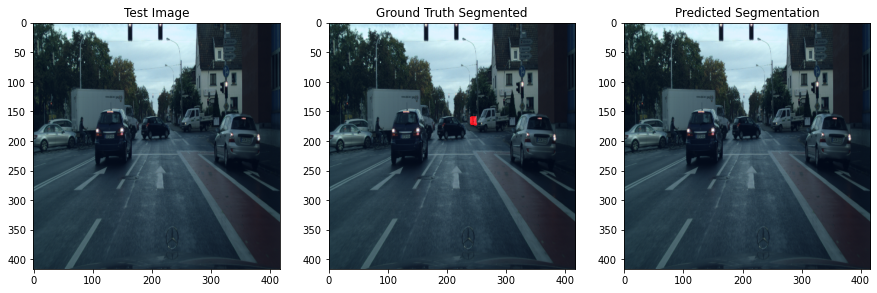

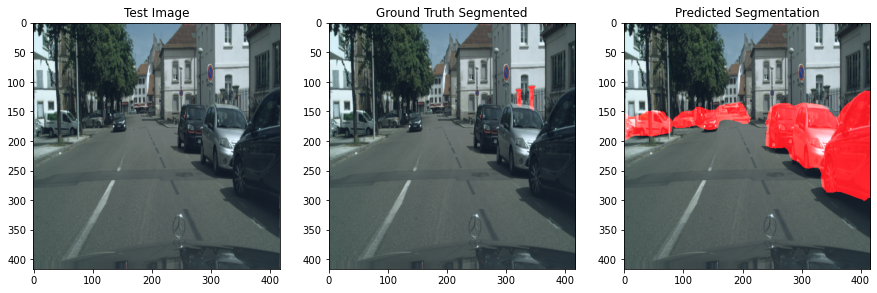

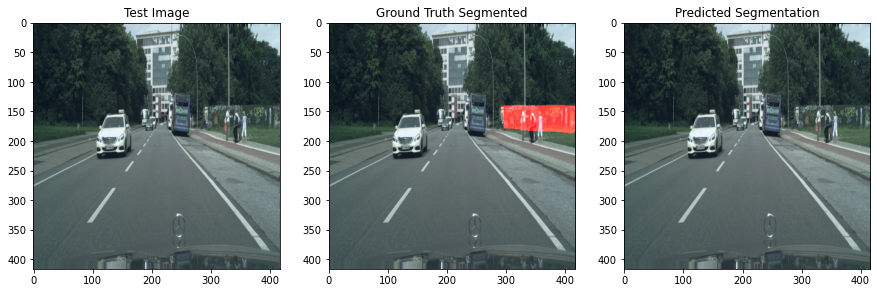

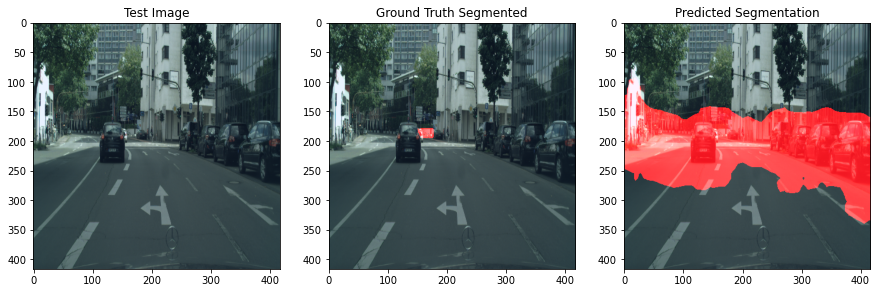

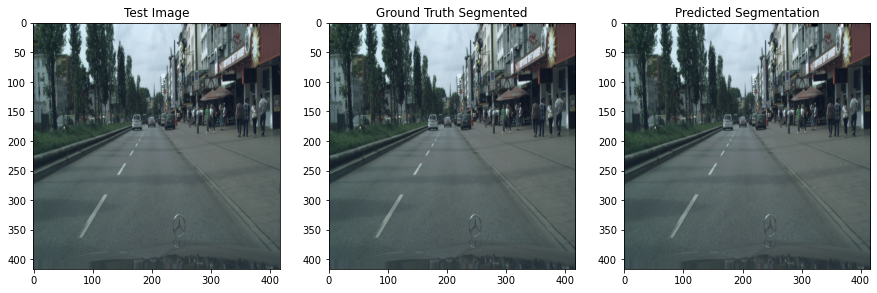

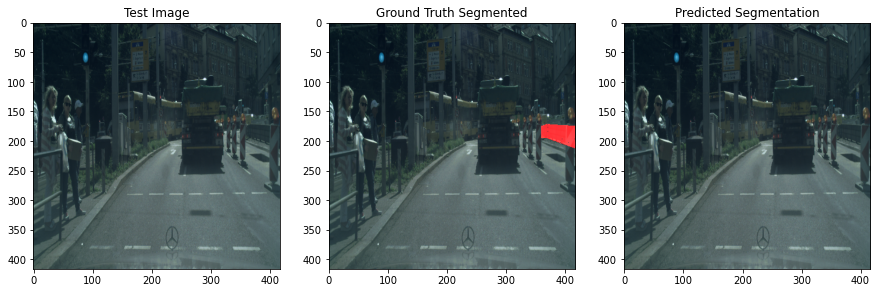

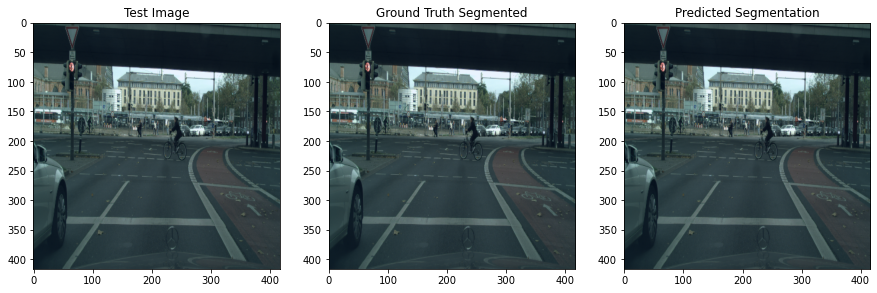

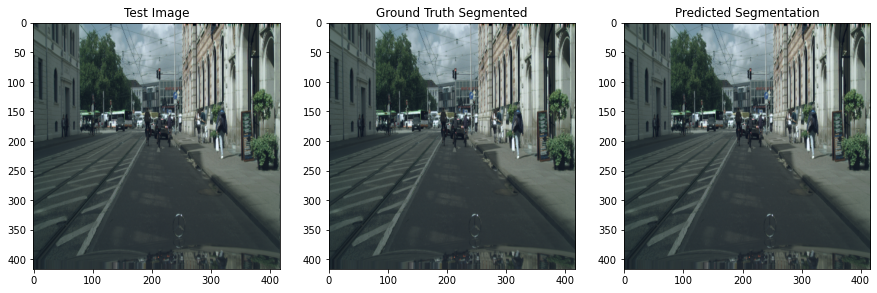

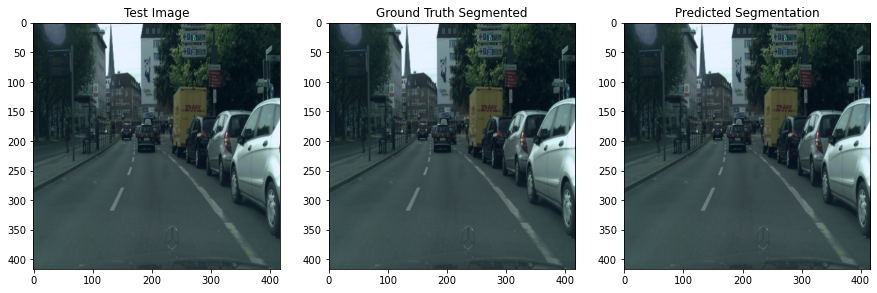

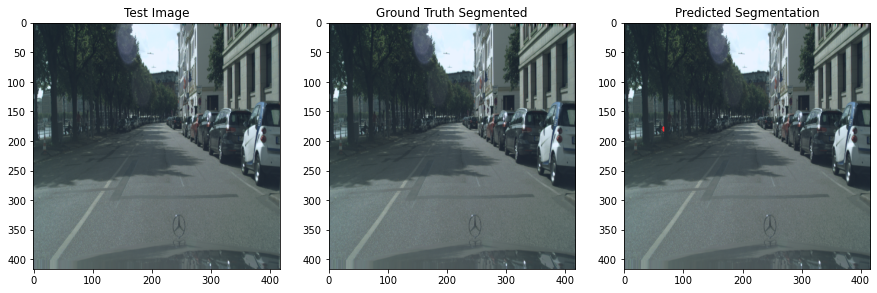

In [17]:
#Prediction 
idx=0

for idx in range(3):
    iterator=iter(train_loader)
    sample=iterator.next()
    support_img=[[shot for shot in way]
                    for way in sample['support_images']]
    fg_mask=[[shot[f'fg_mask'].float() for shot in way]
                    for way in sample['support_mask']]
    bg_mask=[[shot[f'bg_mask'].float() for shot in way]
                    for way in sample['support_mask']]
    query_img= [query
                for query in sample['query_images']]
    query_gt = torch.cat([queryGT.long()
                            for queryGT in sample['query_labels']], dim=0)

    model=model_eval.to(device="cpu")
    model.eval()
    with torch.no_grad():
        pred_query,lossPAR= model(support_img,fg_mask,bg_mask,query_img)

    pred=np.array(pred_query.argmax(dim=1)[0].cpu())
    gt_query=query_gt[0,:,:].cpu().numpy()

    test=query_img[0][0].cpu().numpy()
    test=np.transpose(test,(1,2,0))
    testn=cv2.normalize(test, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    overlay=np.zeros_like(test)
    gt_overlay=np.zeros_like(test)

    overlay[:,:,0]=1.0
    overlay[:,:,0]=overlay[:,:,0]*pred

    gt_overlay[:,:,0]=1.0
    gt_overlay[:,:,0]=gt_overlay[:,:,0]*gt_query

    test_gt=cv2.addWeighted(testn,1,gt_overlay,0.9,0)
    test_pred=cv2.addWeighted(testn,1,overlay,0.9,0)

    plt.figure(idx,figsize=(15,15))
    ax=plt.subplot(1,3,1)
    ax.imshow(testn)
    ax.title.set_text("Test Image")
    ax=plt.subplot(1,3,2)
    ax.imshow(test_gt)
    ax.title.set_text("Ground Truth Segmented")
    ax=plt.subplot(1,3,3)
    ax.imshow(test_pred)
    ax.title.set_text("Predicted Segmentation")

In [52]:
max_label = 20
metric = Metric(max_label=max_label, n_runs=1)
classIoU, meanIoU = metric.get_mIoU(labels=sorted(labels), n_run=30000)
classIoU_binary, meanIoU_binary = metric.get_mIoU_binary(n_run=30000)

IndexError: list index out of range

In [ ]:
import json 

dir= "./test_models/info/fs_0906182026.json"
openfile=open(dir, "r")
setup= json.load(openfile)

print(setup)

{'input dims': [417, 417], 'steps': 30000, 'ways': 1, 'shots': 1, 'num_queries': 1, 'batch_size': 1, 'learning_rate': 0.001, 'distfunc': 'cosine', 'backbone': 'dv3', 'dataset': 'VOC', 'desctiption': 'Experiment1: baseline with dv3 encoder', 'optimizer': 'SGD (\nParameter Group 0\n    dampening: 0\n    initial_lr: 0.001\n    lr: 0.001\n    maximize: False\n    momentum: 0.9\n    nesterov: False\n    weight_decay: 5e-05\n)', 'epochs': 1}
